In [1]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    ParameterGrid,
)
from sklearn.preprocessing import StandardScaler

from typing import List, Tuple

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_data() -> Tuple[List, List]:
    X, y = make_blobs(
        n_samples=1000,
        centers=2,
        cluster_std=3.8,
        center_box=(-6.0, 6.0),
        random_state=42,
    )

    return X, y

In [3]:
X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

<Axes: xlabel='feat1', ylabel='feat2'>

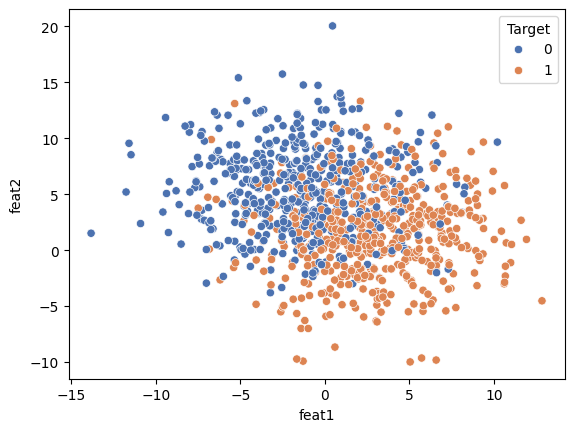

In [4]:
df = pd.DataFrame(X, columns=["feat1", "feat2"])
df["Target"] = y

sns.scatterplot(data=df, x="feat1", y="feat2", hue="Target", palette="deep")

Получили достаточно сильно пересекающиеся признаки

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import clone

In [7]:
def gini_score(y_true, y_prob) -> float:
    auc = roc_auc_score(y_true, y_prob)
    return 2 * auc - 1

Делаем обучение scaler внутри кажддого фола, чтобы избежать leakage

In [8]:
logreg = LogisticRegression(max_iter=1000)
svm = SVC(probability=True)
tree = DecisionTreeClassifier(random_state=42)
forest = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def grid_search_with_scaling(model, param_grid, X, y):
    best_score = -1
    best_model = None
    best_params = None

    for params in ParameterGrid(param_grid):
        fold_scores = []

        for train_idx, val_idx in cv.split(X, y):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]

            scaler = StandardScaler()
            X_tr_scaled = scaler.fit_transform(X_tr)
            X_val_scaled = scaler.transform(X_val)

            m = clone(model)
            m.set_params(**params)
            m.fit(X_tr_scaled, y_tr)

            y_prob = m.predict_proba(X_val_scaled)[:, 1]
            auc = roc_auc_score(y_val, y_prob)
            fold_scores.append(auc)

        mean_auc = sum(fold_scores) / len(fold_scores)

        if mean_auc > best_score:
            best_score = mean_auc
            best_params = params

    final_scaler = StandardScaler()
    X_train_scaled = final_scaler.fit_transform(X_train)
    X_test_scaled = final_scaler.transform(X_test)

    best_model = clone(model).set_params(**best_params)
    best_model.fit(X_train_scaled, y_train)

    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
    gini = gini_score(y_test, y_prob)

    return best_params, gini


def pipeline():
    params = {
        "logreg": {"C": [0.1, 1, 10]},
        "svm": {"C": [0.1, 1, 10], "gamma": [0.01, 0.1, 1]},
        "tree": {"max_depth": [5, 10, 20], "min_samples_split": [2, 5, 10]},
        "forest": {"n_estimators": [10, 50, 100], "max_depth": [5, 10, 20]},
    }

    models = {"logreg": logreg, "svm": svm, "tree": tree, "forest": forest}

    for i, (name, model) in enumerate(models.items(), 1):

        print(f"{i} модель {name}")

        if name in ["tree", "forest"]:
            grid = GridSearchCV(
                model, params[name], cv=cv, scoring="roc_auc", n_jobs=-1
            )
            grid.fit(X_train, y_train)

            best = grid.best_estimator_
            y_prob = best.predict_proba(X_test)[:, 1]
            gini = gini_score(y_test, y_prob)

            print(f"Лучшие параметры: {grid.best_params_}")
            print(f"Gini: {gini:.4f}\n")

        else:
            best_params, gini = grid_search_with_scaling(
                model, params[name], X_train, y_train
            )

            print(f"Лучшие параметры: {best_params}")
            print(f"Gini: {gini:.4f}\n")


pipeline()

1 модель logreg
Лучшие параметры: {'C': 10}
Gini: 0.8136

2 модель svm
Лучшие параметры: {'C': 0.1, 'gamma': 0.1}
Gini: 0.8152

3 модель tree
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 10}
Gini: 0.6884

4 модель forest
Лучшие параметры: {'max_depth': 5, 'n_estimators': 100}
Gini: 0.7842



Исходя из получениых значений, видим, что наиболее хорошо себя показала модель SVM
- У svm низкое значение {"C":0.1} означает, что модель не пыталась подстроиться под каждую точку, а искала наиболее ирокую полосу разделения. И gamma: 0.1 указывает на малое влияяние отдельных точек-выбросов

- У logreg наилучий параметр С: 10 заначит слабую регуляризацию и исходя из модели svm можно сделать вывод, что граница между признаками - это прямая линия

---

- У случайного леса третий по кэффициенту Gini результат, она уступила линейным моделям, 100 деревье помогли сгладить результат

- Дерево тут слишком сильно старадает от шума, оно даже с глубиной 5 строит слишком грубу линию

### Вывод: 
- Лучшая: svm 
- Logreg: хороша своей простотой и интерпретируемостью
- Random Forest: Изыточна для данной геометрии данных 
- Tree: слишком грубая и неустойчивая к шуму 

# Вресия с pipeline sklearn

In [9]:
models = {
    "logreg": LogisticRegression(max_iter=1000),
    "svm": SVC(probability=True),
    "tree": DecisionTreeClassifier(random_state=42),
    "forest": RandomForestClassifier(random_state=42),
}

params = {
    "logreg": {"model__C": [0.1, 1, 10]},
    "svm": {"model__C": [0.1, 1, 10], "model__gamma": [0.01, 0.1, 1]},
    "tree": {"model__max_depth": [5, 10, 20], "model__min_samples_split": [2, 5, 10]},
    "forest": {"model__n_estimators": [50, 100], "model__max_depth": [5, 10, 20]},
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def pipeline(X_train, y_train, X_test, y_test):
    for i, (name, model) in enumerate(models.items(), 1):

        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])

        grid = GridSearchCV(pipe, params[name], cv=cv, scoring="roc_auc", n_jobs=-1)

        grid.fit(X_train, y_train)

        y_prob = grid.predict_proba(X_test)[:, 1]
        gini = gini_score(y_test, y_prob)

        print(f"{i}. модель {name}")
        print(f"Лучшие параметры: {grid.best_params_}")
        print(f"Gini: {gini:.4f}\n")


pipeline(X_train, y_train, X_test, y_test)

1. модель logreg
Лучшие параметры: {'model__C': 10}
Gini: 0.8136

2. модель svm
Лучшие параметры: {'model__C': 0.1, 'model__gamma': 0.1}
Gini: 0.8150

3. модель tree
Лучшие параметры: {'model__max_depth': 5, 'model__min_samples_split': 10}
Gini: 0.6884

4. модель forest
Лучшие параметры: {'model__max_depth': 5, 'model__n_estimators': 100}
Gini: 0.7842

